In [20]:
import copy
import os
import time
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm


In [21]:
# download en_core_web_sm with "python -m spacy download en_core_web_sm"
nlp = spacy.load("en_core_web_sm")
data_path = "data/"

# k for the k most occuring words
k = 5000

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = torch.device("cpu")

In [22]:
def load(split):
    res = defaultdict(tuple)
    with open(os.path.join(data_path, f'{split}_text.txt'), encoding="utf-8") as f:
        text = f.readlines()
    
    with open(os.path.join(data_path, f'{split}_labels.txt'), encoding="utf-8") as f:
        labels = f.readlines()

    for i, (t, l) in enumerate(zip(text, labels)):
        t = [token.text for token in nlp(t.strip())]
        res[i] = (t, int(l.strip()))
    return res


train_data = load("train")
val_data = load("val")
test_data = load("test")

In [23]:
with open(os.path.join(data_path, "mapping.txt")) as f:
    mapping = {int(line.split()[0]): line.split()[1] for line in f}

In [24]:
UNK = "<UNK>"
frequencies = defaultdict(int)
for features, _ in train_data.values():
    for token in features:
        frequencies[token] += 1
frequencies = sorted(frequencies, key=frequencies.get, reverse=True)[:k]

word2idx = {word: i for i, word in enumerate(frequencies)}
word2idx[UNK] = len(word2idx)
unk = word2idx[UNK]

In [25]:
class LSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_layers, vocab_size, out_dim, pad_idx):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        embeds = self.embed(x)
        lstm_out, (hidden, cell) = self.lstm(embeds)
        output = self.fc(hidden[-1])
        return output.unsqueeze(0)
    

class GRU(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_layers, vocab_size, out_dim, pad_idx):
        super(GRU,self).__init__()
        self.hidden_dim = hidden_dim
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        embeds = self.embed(x)
        gru_out, hidden = self.gru(embeds)
        output = self.fc(hidden[-1])
        return output.unsqueeze(0)

In [26]:
def prepare_sequence(words, word2idx):
    idxs = [word2idx.get(word, unk) for word in words] 
    return torch.tensor(idxs, dtype=torch.long)                        

In [27]:
def train_single_line(model=None,
                      data=None,
                      vocab=None,
                      criterion=None,
                      optimizer=None,
                      epochs=0,
                      device=None
                    ):
    s_time = time.time()
    model.train()
    stats = defaultdict(list)
    for epoch in range(epochs):
        epoch_loss = 0
        with tqdm(total=len(data), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for i, (features, label) in data.items():
                optimizer.zero_grad()
                sentence_in = prepare_sequence(features, vocab)
                targets = torch.tensor([label], dtype=torch.long)
                sentence_in, targets = sentence_in.to(device), targets.to(device)
                
                output = model(sentence_in)
                loss = criterion(output, targets)
                loss.backward()
                optimizer.step()
                stats["loss"].append(loss.item())
                epoch_loss += loss.item()

                predicted = torch.argmax(output)
                stats["correct"].append((predicted == targets).item())
                stats["total"].append(1)
            
                pbar.update(1)


            epoch_loss /= len(data)
            accuracy = sum(stats["correct"]) / sum(stats["total"])
            
            pbar.set_postfix_str(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f} Accuracy: {accuracy:.4f}")

            
    
    print(f"Done. ({time.time()-s_time:.2f}s)")
    return stats


def test_single_line(model=None,
                     data=None,
                     vocab=None,
                     criterion=None,
                     device=None
                    ):
    s_time = time.time()
    model.eval()
    stats = defaultdict(list)
    with torch.no_grad():
        for i, (features, label) in data.items():
            sentence_in = prepare_sequence(features, vocab)
            targets = torch.tensor([label], dtype=torch.long)            
            sentence_in, targets = sentence_in.to(device), targets.to(device)
            output = model(sentence_in)            
            loss = criterion(output, targets)
            stats["loss"].append(loss.item())

            predicted = torch.argmax(output, dim=1)
            stats["correct"].append((predicted == targets).item())
            stats["total"].append(1)

    loss = sum(stats["loss"]) / len(data)
    accuracy = sum(stats["correct"]) / sum(stats["total"])
    print(f"Test Loss: {loss:.4f} Accuracy: {accuracy:.4f}")
    print(f"Done. ({time.time()-s_time:.2f}s)")
    return stats

# 

In [28]:
lstm = LSTM(EMBEDDING_DIM, HIDDEN_DIM, 1, len(word2idx), 4, word2idx[UNK])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)

train_stats_lstm = train_single_line(model=lstm,
                                data=train_data,
                                vocab=word2idx,
                                criterion=criterion,
                                optimizer=optimizer,
                                epochs=10,
                                device=DEVICE
                               )

test_stats_lstm = test_single_line(model=lstm,
                                data=test_data,
                                vocab=word2idx,
                                criterion=criterion,
                                device=DEVICE
                                 )

Epoch 1/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Done. (118.98s)
Test Loss: 1.9267 Accuracy: 0.3835
Done. (0.63s)


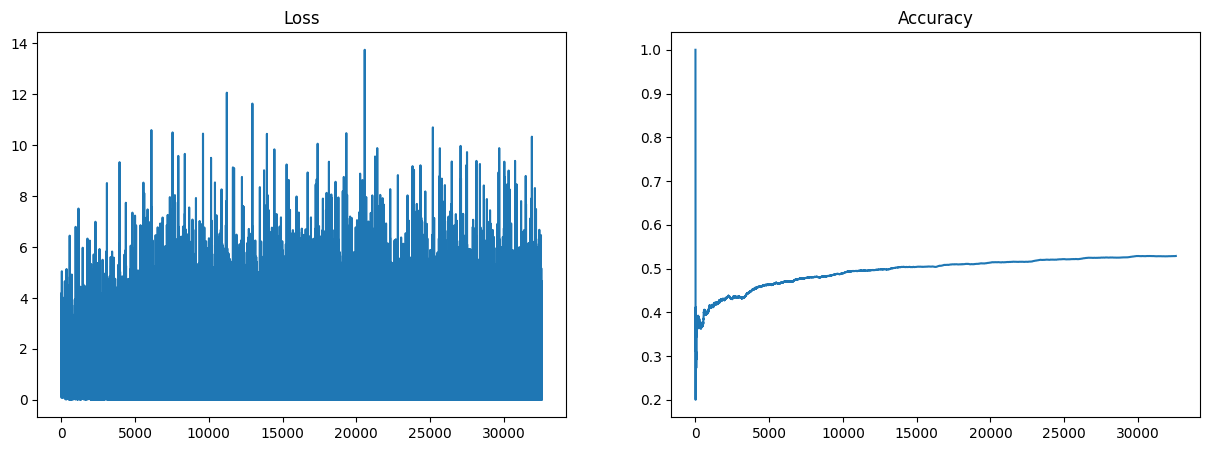

In [29]:
import seaborn as sns
def plot_stats(stats):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(stats["loss"])
    ax[0].set_title("Loss")
    ax[1] = sns.lineplot(x=range(len(stats["correct"])), y=np.cumsum(stats["correct"]) / np.cumsum(stats["total"]))
    ax[1].set_title("Accuracy")
    plt.show()

plot_stats(train_stats_lstm)

Epoch 1/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/3257 [00:00<?, ?it/s]

Done. (233.62s)
Test Loss: 2.9867 Accuracy: 0.3519
Done. (1.49s)


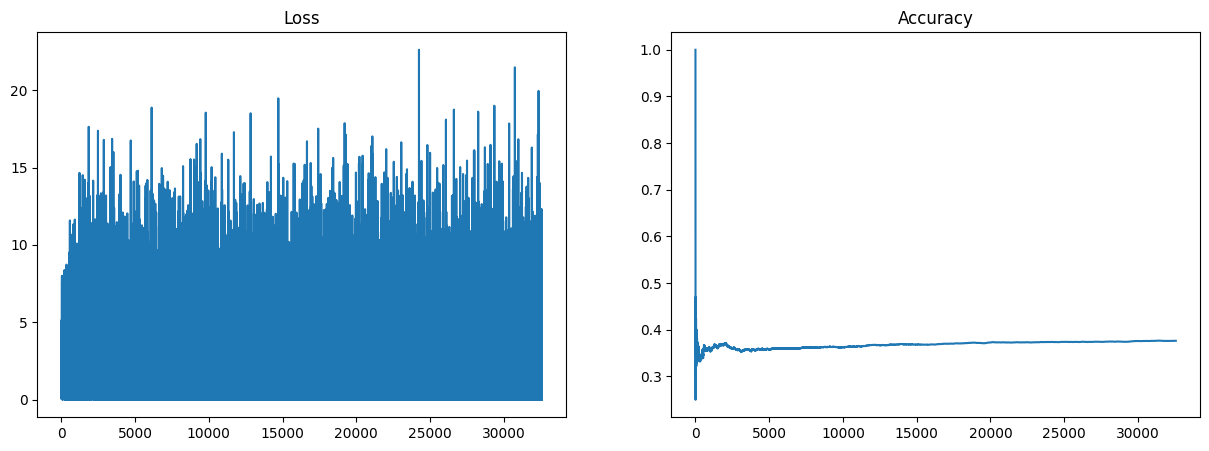

In [30]:
gru = GRU(EMBEDDING_DIM, HIDDEN_DIM, 1, len(word2idx), 4, word2idx[UNK])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru.parameters(), lr=0.01)

train_stats_gru = train_single_line(model=gru,
                                data=train_data,
                                vocab=word2idx,
                                criterion=criterion,
                                optimizer=optimizer,
                                epochs=10,
                                device=DEVICE
                               )

test_stats_gru = test_single_line(model=gru,
                                data=test_data,
                                vocab=word2idx,
                                criterion=criterion,
                                device=DEVICE
                                 )

plot_stats(train_stats_gru)

In [31]:
PAD = "<PAD>"
word2idx[PAD] = len(word2idx)

def collate_fn(batch):
    max_len = max([len(features) for features, _ in batch])
    features, labels = zip(*batch)
    transformed = [[word2idx.get(word, unk) for word in sentence] for sentence in features]
    features = [f + [word2idx[PAD]] * (max_len - len(f)) for f in transformed]

    return torch.tensor(features), torch.tensor(labels)


In [32]:
dataloader_train = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
dataloader_val = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
dataloader_test = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
def train(model=None,
          dataloader_train=None,
          dataloader_val=None,
          optimizer=None,
          criterion=None,
          epochs=10,
          lr=0.01,
          device="cpu",
          val_freq=1,
          ckpt_freq=1,
          **kwargs
          ):

    stats = defaultdict(list)
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        with tqdm(total=len(dataloader_train), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for features, labels in dataloader_train:
                
                features, labels = features.to(device), labels.to(device)
                
                optimizer.zero_grad()                               
                output = model(features).squeeze(0)            
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()

                correct = (output.argmax(1) == labels).float().sum()
                acc = correct / len(labels)

                epoch_loss += loss.item()
                epoch_acc += acc.item()
                
            epoch_loss /= len(dataloader_train)
            epoch_acc /= len(dataloader_train)

            stats["epoch"].append(epoch)
            stats["loss"].append(epoch_loss)
            stats["acc"].append(epoch_acc)

            pbar.set_postfix(loss=epoch_loss, acc=epoch_acc)
            
            if (epoch + 1) % val_freq == 0:
                model.eval()
                val_loss = 0
                val_acc = 0
                with torch.no_grad():
                    for features, labels in dataloader_val:
                        features, labels = features.to(device), labels.to(device)
                        output = model(features).squeeze(0)
                        loss = criterion(output, labels)
                        correct = (output.argmax(1) == labels).float().sum()
                        acc = correct / len(labels)
                        val_loss += loss.item()
                        val_acc += acc.item()
                val_loss /= len(dataloader_val)
                val_acc /= len(dataloader_val)

                stats["val_epoch"].append(epoch)
                stats["val_loss"].append(val_loss)
                stats["val_acc"].append(val_acc)

            
            pbar.set_postfix_str(f"Epoch {epoch+1}/{epochs} Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}")
            pbar.update(1)


    return stats

def test(model=None, dataloader=None, criterion=None, device="cpu"):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            output = model(features).squeeze(0)
            loss = criterion(output, labels)
            correct = (output.argmax(1) == labels).float().sum()
            acc = correct / len(labels)
            test_loss += loss.item()
            test_acc += acc.item()
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

In [34]:
model = LSTM(embed_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=1, vocab_size=len(word2idx)+1, out_dim=4, pad_idx=word2idx[PAD])
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

stats = train(model=model, dataloader_train=dataloader_train, dataloader_val=dataloader_val, optimizer=optimizer, criterion=criterion, epochs=10, device=device)

Epoch 1/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/204 [00:00<?, ?it/s]

RuntimeError: Expected target size [1, 4], got [1]

In [38]:
test_loss, test_acc = test(model=model, dataloader=dataloader_test, criterion=criterion, device=device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

Test Loss: 1.5919 Test Accuracy: 0.4996


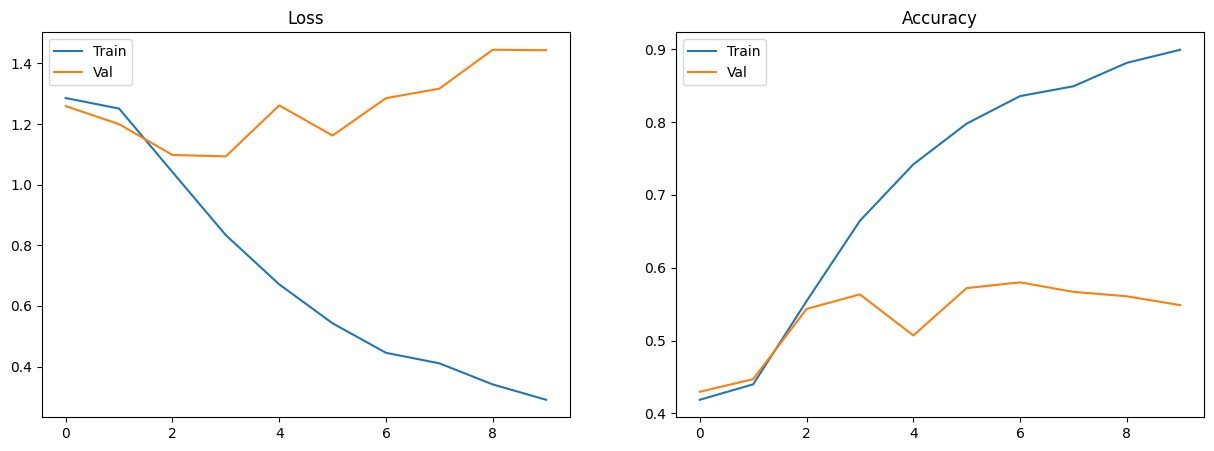

In [37]:
def plot_stats(stats):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(stats["loss"], label="Train")
    ax[0].plot(stats["val_loss"], label="Val")
    ax[0].set_title("Loss")
    ax[0].legend()
    ax[1].plot(stats["acc"], label="Train")
    ax[1].plot(stats["val_acc"], label="Val")
    ax[1].set_title("Accuracy")
    ax[1].legend()
    plt.show()
plot_stats(stats)

In [49]:
model = GRU(embed_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=1, vocab_size=len(word2idx)+1, out_dim=4, pad_idx=word2idx[PAD])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
model.to(device)

stats = train(model=model, dataloader_train=dataloader_train, dataloader_val=dataloader_val, optimizer=optimizer, criterion=criterion, epochs=10, device=device)

Epoch 1/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/204 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/204 [00:00<?, ?it/s]

In [50]:
test_loss, test_acc = test(model=model, dataloader=dataloader_test, criterion=criterion, device=device)
print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

Test Loss: 1.5709 Test Accuracy: 0.6066


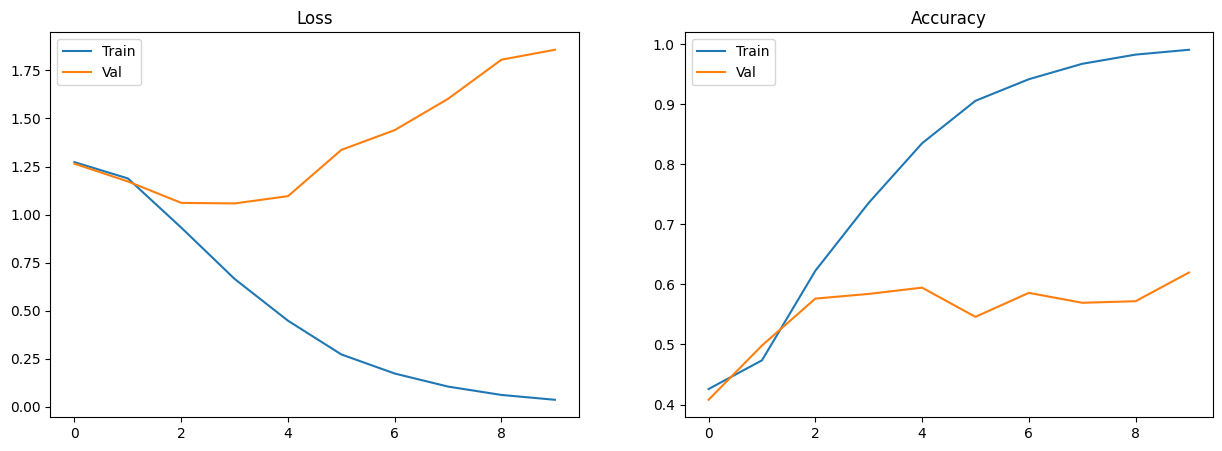

In [51]:
plot_stats(stats)